In [1]:
# OpenCV and Math
import cv2
import numpy as np
from matplotlib import pyplot as plt

# Python 
from pathlib import Path
import logging
import math

# Our module
from module.getSwt import get_swt
from module.connectComponents import connect_components
from module.findLetters import find_letters
from module.findWords import find_words

In [2]:
OUTPUT_FOLDER = 'output/'
INPUT_IMAGE = '../../images/16.jpg'

In [3]:
# Creating Logger manager

LOGGER = logging.getLogger(__name__)

In [4]:
# Checking existing file?

image_file = Path(INPUT_IMAGE)
if not image_file.is_file() or INPUT_IMAGE.split('.')[-1] not in ['jpg', 'JPG', 'jpeg', 'JPEG']:
    LOGGER.error('File is not JPEG type.')   

In [5]:
# -1- Pre-processing step

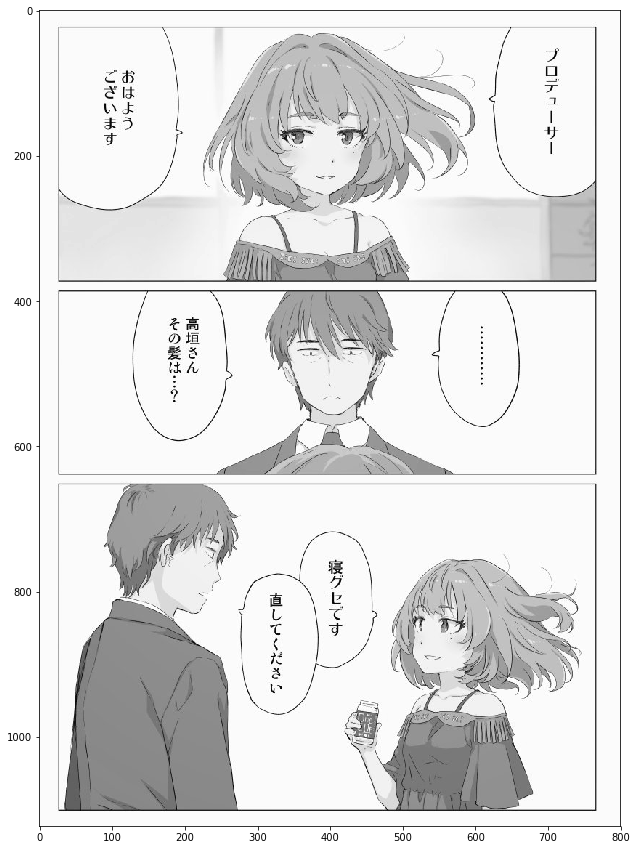

In [6]:
SRC = cv2.imread(INPUT_IMAGE)
SRC_GRAY = cv2.cvtColor(SRC, cv2.COLOR_BGR2GRAY)
HEIGHT, WIDTH = SRC.shape[:2]

fig = plt.figure(figsize=(15, 15))
ax = fig.add_subplot(111)
ax.imshow(SRC_GRAY, cmap='gray', interpolation='none')

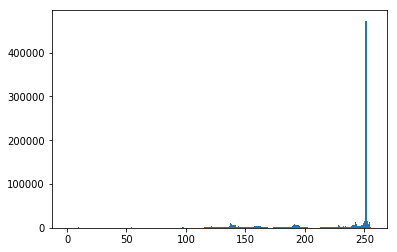

In [7]:
# SRC_GRAY's histogram

plt.hist(SRC_GRAY.ravel(),256,[0,256])
plt.show()

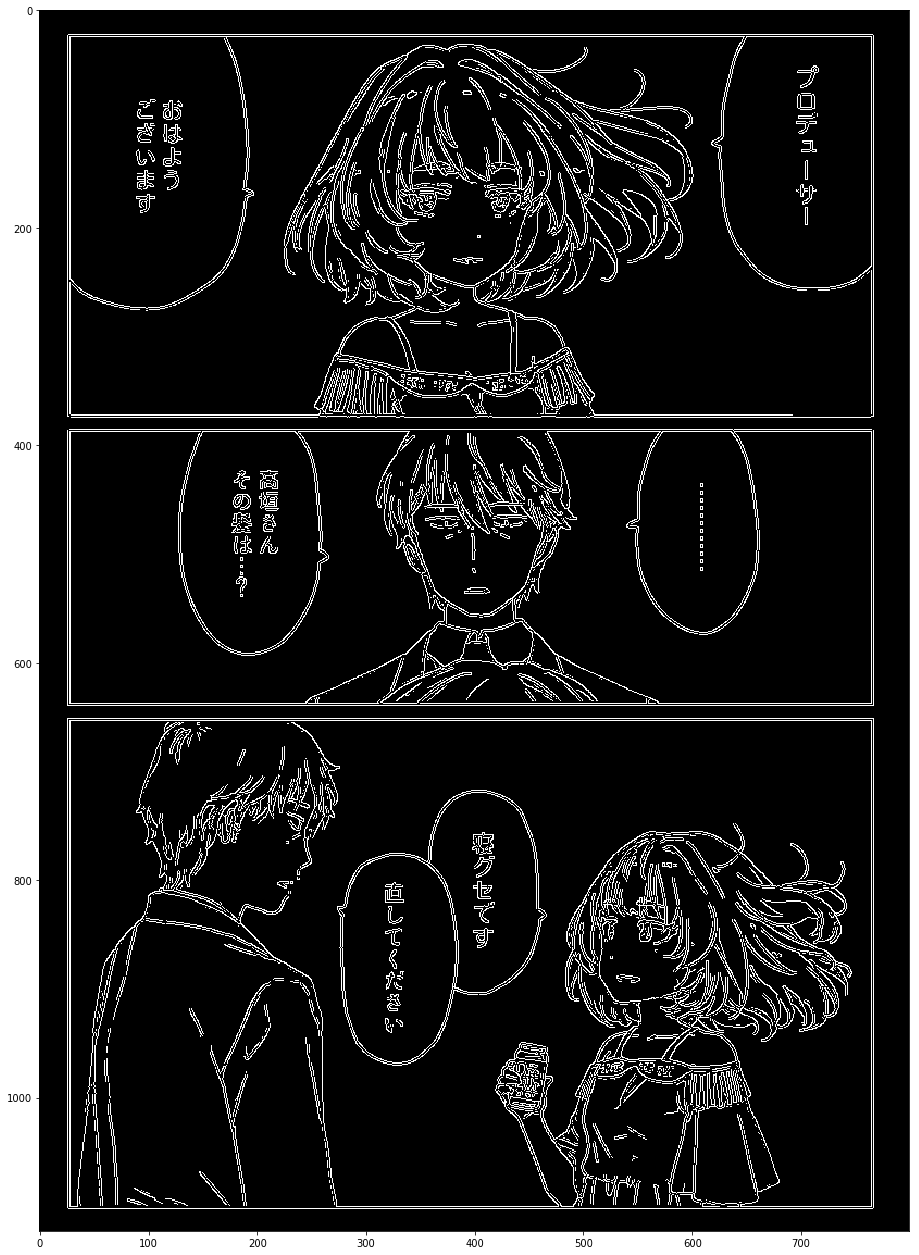

In [8]:
EDGES = cv2.Canny(SRC_GRAY, 100, 150)

fig = plt.figure(figsize=(WIDTH/50, HEIGHT/50))
ax = fig.add_subplot(111)
ax.imshow(EDGES, cmap='gray', interpolation='none')

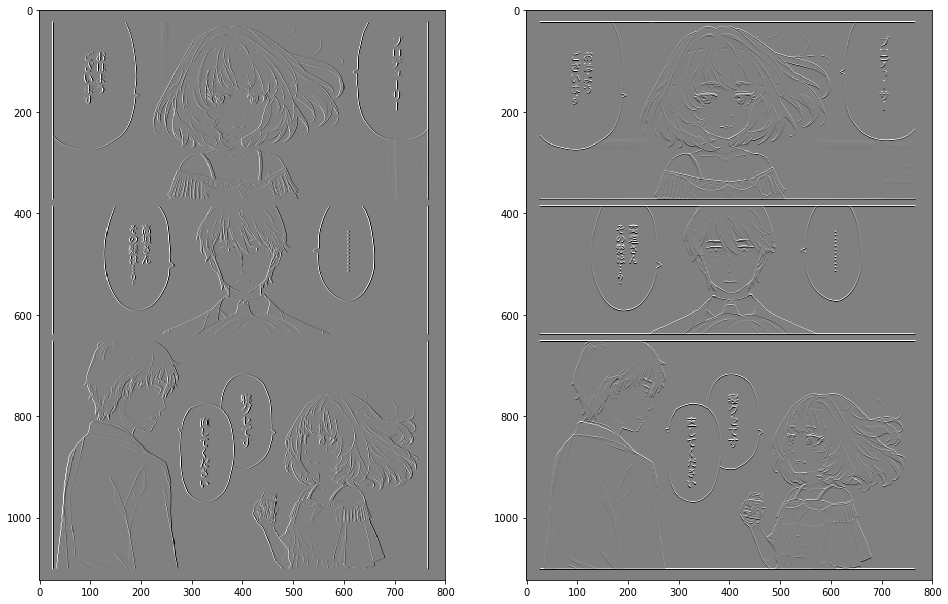

In [9]:
# Get Magnitude and gradient angel
        
invert_gray_image = cv2.bitwise_not(SRC_GRAY)
SOBEL_X = cv2.Sobel(invert_gray_image, cv2.CV_64F, 1, 0)
SOBEL_Y = cv2.Sobel(invert_gray_image, cv2.CV_64F, 0, 1)

fig = plt.figure(figsize=(WIDTH/50, HEIGHT/50))

ax = fig.add_subplot(121)
ax.imshow(SOBEL_X, cmap='gray', interpolation='none')

ax = fig.add_subplot(122)
ax.imshow(SOBEL_Y, cmap='gray', interpolation='none')

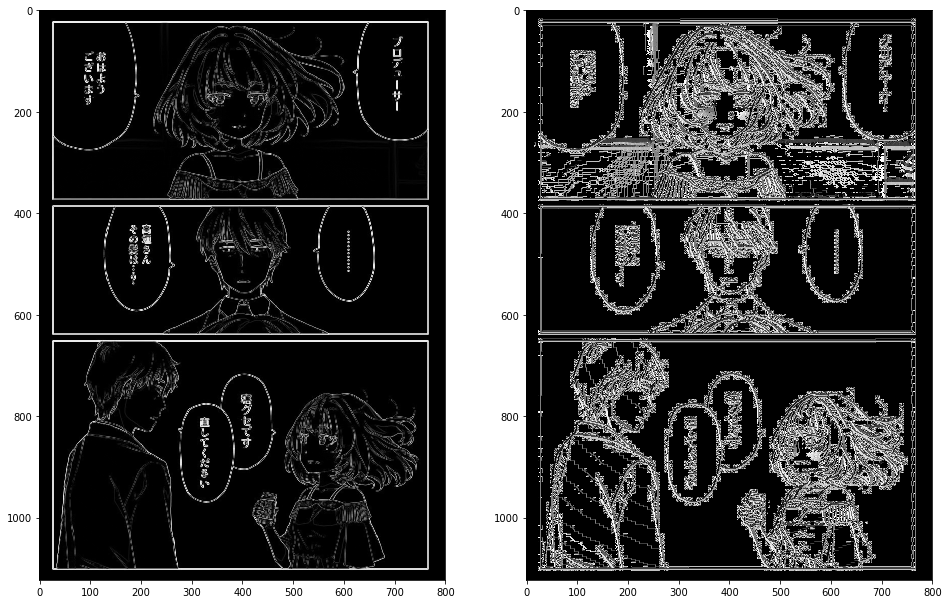

In [10]:
# Getting magnitude and direction of drawing

MAGNITUDE, DIRECTION = cv2.cartToPolar(SOBEL_X, SOBEL_Y)

fig = plt.figure(figsize=(WIDTH/50, HEIGHT/50))

ax = fig.add_subplot(121)
ax.imshow(MAGNITUDE, cmap='gray', interpolation='none')

ax = fig.add_subplot(122)
ax.imshow(DIRECTION, cmap='gray', interpolation='none')

In [11]:
# -2- Get swt step

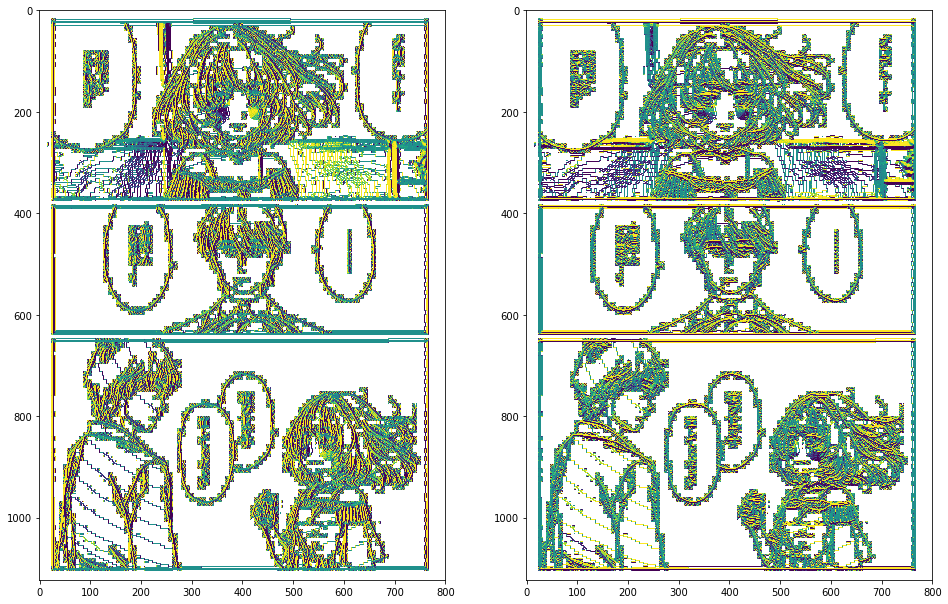

In [12]:
# Ignore error from divide by zero
np.seterr(divide='ignore', invalid='ignore')

step_x_g = SOBEL_X
step_y_g = SOBEL_Y

grad_x_g = np.divide(step_x_g, MAGNITUDE)
grad_y_g = np.divide(step_y_g, MAGNITUDE)

fig = plt.figure(figsize=(WIDTH/50, HEIGHT/50))

ax = fig.add_subplot(121)
ax.imshow(grad_x_g)

ax = fig.add_subplot(122)
ax.imshow(grad_y_g)

In [14]:
rays = []
swt = np.empty(EDGES.shape)
swt[:] = np.Infinity

for y in range(HEIGHT):
    for x in range(WIDTH):
        if EDGES[y][x] != 0:
            cur_x, cur_y = x, y
            grad_x = grad_x_g[y, x]
            grad_y = grad_y_g[y, x]

            ray = [{'x': x, 'y': y}]
            i = 0

            while True:
                i += 1
                try:
                    cur_x = math.floor(x + grad_x * i)
                    cur_y = math.floor(y + grad_y * i)
                except ValueError:
                    # Catch Nan value
                    break

                try:
                    ray.append({'x': cur_x, 'y': cur_y})
                    if EDGES[cur_y][cur_x] != 0:
                        # Filter value which is out of domain
                        if (grad_x * -grad_x_g[cur_y, cur_x] + grad_y * -grad_y_g[cur_y, cur_x] >= -1 and
                            grad_x * -grad_x_g[cur_y, cur_x] + grad_y * -grad_y_g[cur_y, cur_x] <= 1):
                            if math.acos(grad_x * -grad_x_g[cur_y, cur_x] + grad_y * -grad_y_g[cur_y, cur_x]) < np.pi/2.0:
                                thickness = math.sqrt( (cur_x - x) * (cur_x - x) + (cur_y - y) * (cur_y - y) )
                                rays.append(ray)
                                
                                for pos in ray:
                                    if min(thickness, swt[pos['y'], pos['x']]) > 50:
                                        continue
                                    swt[pos['y'], pos['x']] = min(thickness, swt[pos['y'], pos['x']])
                        break
                except IndexError:
                    break

In [15]:
for ray in rays:
    median = np.median([swt[pos['y'], pos['x']] for pos in ray])
    for pos in ray:
        swt[pos['y'], pos['x']] = min(median, swt[pos['y'], pos['x']])

<IPython.core.display.Javascript object>


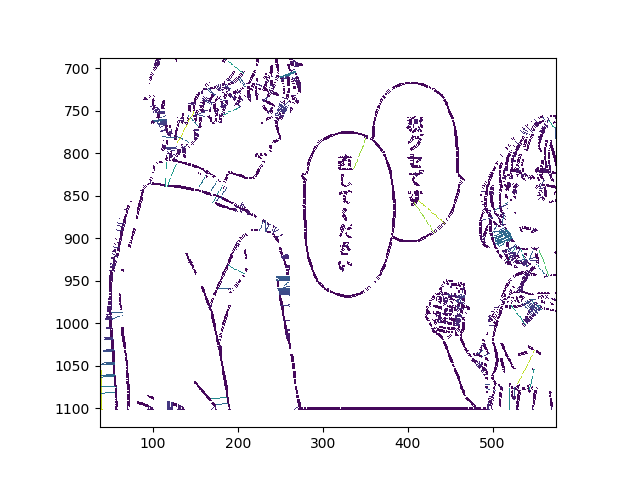

In [16]:
fig = plt.figure(figsize=(WIDTH/50, HEIGHT/50))

%matplotlib notebook

# ax = fig.add_subplot(111)
# ax.imshow(swt)

plt.imshow(swt)
